# 0.0 IMPORTS

In [55]:
import pandas as pd
from IPython.display import HTML, display
import warnings
from sklearn import cluster as c
from sklearn import metrics as m
from yellowbrick.cluster import KElbowVisualizer
from plotly import express as px

## 0.1 HELPER FUNCTIONS

In [22]:
def jupyter_settings():
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

jupyter_settings();
warnings.filterwarnings("ignore");

## 0.2 LOADING DATA 

In [23]:
df_raw = pd.read_pickle('dataset/df_raw.pkl')

# 1.0 DATA DESCRIPTION

In [24]:
df1 = df_raw.copy()

## 1.1 DATA DIMENSIONS

In [25]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 541909
Columns: 8


## 1.2 DATA TYPES

In [26]:
df1.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## 1.3 CHECKING NA DATA

In [27]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## 1.4 DROPING NA 

In [28]:
df1 = df1.dropna()

In [29]:
df1.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## 1.5 CHANGING TYPE 

In [30]:
df1['CustomerID'] = df1['CustomerID'].astype(int) 

# 2.0 FEATURE ENGINEERING

In [31]:
df2 = df1.copy()

## 2.1 FEATURE CREATION

In [32]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### 2.1.1 GROSS REVENUE

In [33]:
df2['GrossRevenue'] = df2['Quantity'] * df2['UnitPrice']
df_m = df2[['CustomerID','GrossRevenue']].groupby('CustomerID').sum().reset_index()
df_m.head()

,CustomerID,GrossRevenue
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


### 2.1.2 RECENCY

In [34]:
df_r = df2[['CustomerID','InvoiceDate']].groupby('CustomerID').max().reset_index()
df_r['RecencyDays'] = (df2['InvoiceDate'].max()-df_r['InvoiceDate']).dt.days
df_r.drop('InvoiceDate',axis=1,inplace=True)
df_r.head()

,CustomerID,RecencyDays
0,12346,325
1,12347,1
2,12348,74
3,12349,18
4,12350,309


### 2.1.3 FREQUENCY

In [35]:
df_f = df2[['CustomerID','InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index()
df_f.head()

,CustomerID,InvoiceNo
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


### 2.1.4 MERGING NEW FEATURES

In [36]:
df_ref = pd.merge(df_m,df_r,on='CustomerID',how='left')
df_ref = pd.merge(df_ref,df_f,on='CustomerID',how='left')
df_ref.head()

,CustomerID,GrossRevenue,RecencyDays,InvoiceNo
0,12346,0.00,325,2
1,12347,4310.00,1,7
2,12348,1797.24,74,4
3,12349,1757.55,18,1
4,12350,334.40,309,1


# 3.0 HYPERPARAMETER FINE TUNING

In [40]:
X = df_ref.drop(columns=['CustomerID'])
clusters = [2,3,4,5,6]

## 3.1 WITHIN-CLUSTER SUM OF SQUARES (WSS)

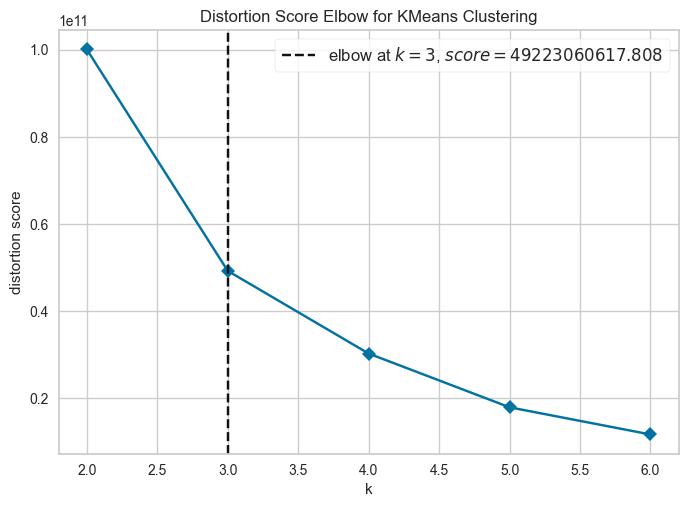

In [48]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

## 3.2 SILHOUETTE SCORE

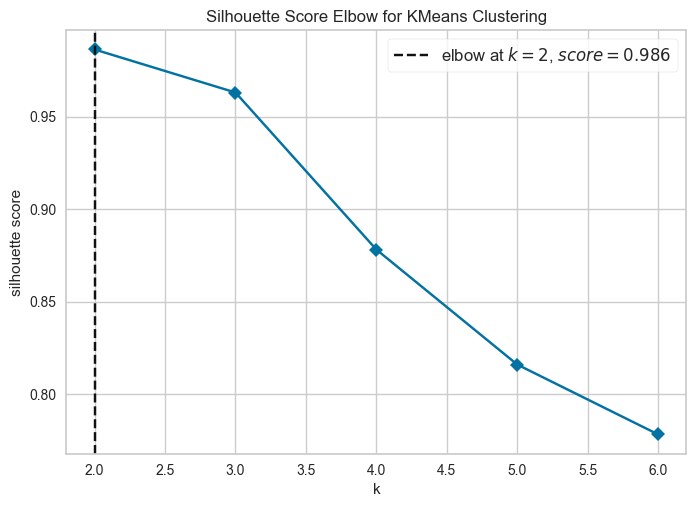

In [47]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters, metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

# 4.0 MODEL TRAINING

In [84]:
k = 4
kmeans = c.KMeans(init='random',n_clusters=k,max_iter=300,random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

In [85]:
print('WSS value:{}'.format(kmeans.inertia_))
print('SS value:{}'.format(m.silhouette_score(X,labels,metric='euclidean')))

WSS value:39986555155.56188
SS value:0.8149167342946387


# 5.0 CLUSTER ANALYSIS

In [86]:
df5 = df_ref.copy()
df5['cluster'] = labels
df5.head()

,CustomerID,GrossRevenue,RecencyDays,InvoiceNo,cluster
0,12346,0.00,325,2,2
1,12347,4310.00,1,7,2
2,12348,1797.24,74,4,2
3,12349,1757.55,18,1,2
4,12350,334.40,309,1,2


## 5.1 VISUALIZATION INSPECTION

In [87]:
fig = px.scatter_3d(df5,x='RecencyDays',y='InvoiceNo',z='GrossRevenue',color='cluster')
fig.show()

## 5.2 CLUSTER PROFILE

In [88]:
#Qty per cluster
df_cluster = df5[['CustomerID','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['CustomerID']/df_cluster['CustomerID'].sum())

#Avg gross rev
df_avg_grossrev = df5[['GrossRevenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_grossrev,how='inner',on='cluster')

#Avg recency days
df_avg_rec = df5[['RecencyDays','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_rec,how='inner',on='cluster')

#Avg invoice num
df_avg_invnum = df5[['InvoiceNo','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_invnum,how='inner',on='cluster')

df_cluster

,cluster,CustomerID,perc_customer,GrossRevenue,RecencyDays,InvoiceNo
0,0,6,0.137237,182181.981667,6.666667,89.000000
1,1,267,6.107045,8089.028652,19.823970,19.528090
2,2,4071,93.115279,946.696250,96.429870,3.641120
3,3,28,0.640439,42614.387143,5.678571,57.821429
